# Pharma Weekly Sales — Forecasting Project

This notebook implements a complete forecasting workflow on the provided weekly pharma sales dataset (Friday-weekly). It contains EDA, feature engineering, XGBoost pipeline (with time-aware CV), and a professional ARIMA/SARIMAX workflow — both models run on the same dataset and their forecasts are compared.

**Files expected:** `pharma_weekly_sales_sample_2019_2021.csv` (placed in the notebook directory)

**Outputs:** model metrics, comparison plots, saved models, and exportable forecasts.


In [6]:
# Cell 1 - Setup & imports
import warnings
warnings.filterwarnings('ignore')

import os
import math
import pickle
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit

# ML libraries
import xgboost as xgb

# Statsmodels / ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Optional helper (auto_arima) - commented out, use if installed
# from pmdarima import auto_arima

sns.set_style('whitegrid')
%matplotlib inline

print('Environment ready')

Environment ready


In [7]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import pandas as pd
import numpy as np
from datetime import datetime
from pathlib import Path
current_dir = Path.cwd()
print("Current directory:", current_dir)

import os
base_path = "/kaggle/input/"
print(os.listdir(base_path))

/kaggle/input/pharma-sales/pharma_weekly_sales_sample_2019_2021.csv
Current directory: /kaggle/working
['pharma-sales']


In [8]:
# Cell 2 - Load data
base_path = "/kaggle/input/pharma-sales/pharma_weekly_sales_sample_2019_2021.csv"
df = pd.read_csv(base_path)

In [9]:
df.sort_values(by=['week_ending'])


,week_ending,year,week_of_year,month,quarter,region,sales_units,avg_price,hcp_count,num_reps,seg_A_pct,seg_B_pct,seg_C_pct,calls_made,samples_dispensed,promo_flag,is_holiday_week
0,2019-01-04,2019,1,1,1,East,1043,454.96,242,16,0.205,0.532,0.263,123,33,0,0
157,2019-01-04,2019,1,1,1,North,1661,462.23,323,22,0.235,0.523,0.242,188,61,0,0
471,2019-01-04,2019,1,1,1,West,1355,455.19,303,20,0.276,0.534,0.190,166,47,0,0
314,2019-01-04,2019,1,1,1,South,1146,446.20,283,18,0.213,0.515,0.271,143,42,0,0
158,2019-01-11,2019,2,1,1,North,1958,458.16,323,22,0.213,0.563,0.224,186,48,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,2021-12-24,2021,51,12,4,East,1689,436.26,240,16,0.163,0.548,0.289,118,39,0,0
313,2021-12-31,2021,52,12,4,North,2706,431.91,320,22,0.205,0.551,0.245,168,55,1,1
156,2021-12-31,2021,52,12,4,East,1370,437.41,240,16,0.206,0.490,0.304,117,41,0,1
470,2021-12-31,2021,52,12,4,South,1789,449.52,280,18,0.192,0.541,0.267,136,36,0,1


In [10]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Ensure datetime and sort
df['week_ending'] = pd.to_datetime(df['week_ending'])
df = df.sort_values('week_ending')

# National aggregation
national = df.groupby('week_ending', as_index=False)['sales_units'].sum()
print("Shape:", national.shape)
display(national.head())


Shape: (157, 2)


,week_ending,sales_units
0,2019-01-04,5205
1,2019-01-11,5531
2,2019-01-18,5667
3,2019-01-25,4700
4,2019-02-01,5898


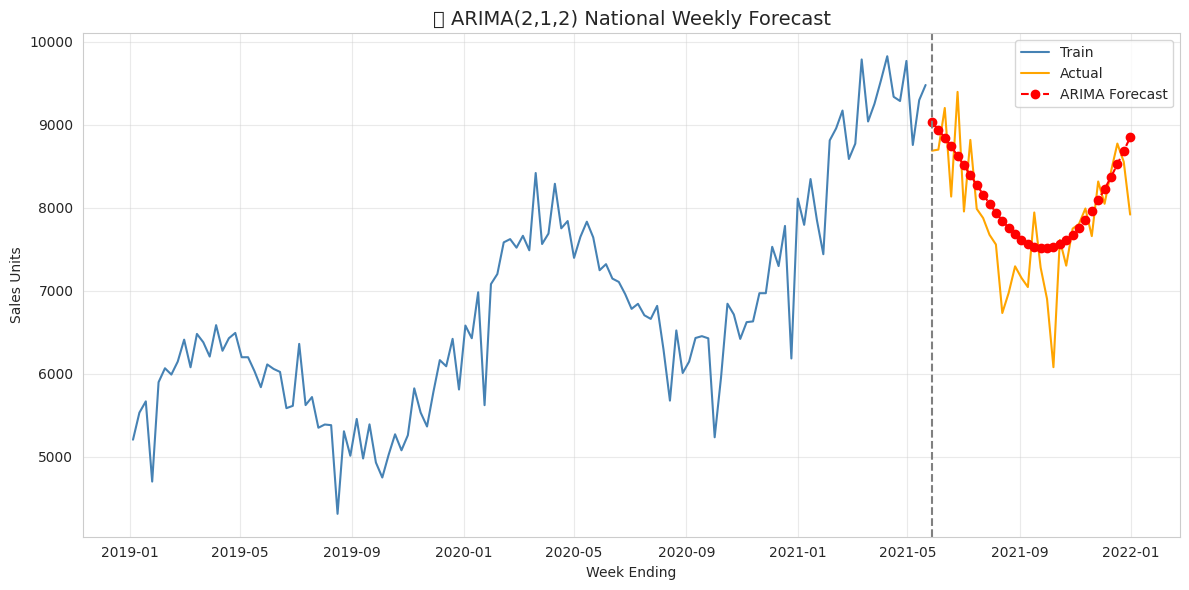

In [11]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import pandas as pd

# --- National aggregation ---
df['week_ending'] = pd.to_datetime(df['week_ending'])
national = df.groupby('week_ending', as_index=False)['sales_units'].sum().sort_values('week_ending')

# --- Split ---
split = int(0.8 * len(national))  # 80% index
train = national.iloc[:split]
test  = national.iloc[split:]


# --- Manual ARIMA model ---
model_arima = ARIMA(
    endog = train['sales_units'],
    order = (2,0,2),              # (p,d,q)
    trend = 'ct',
    enforce_stationarity = True,
    enforce_invertibility = True
)
fit_arima = model_arima.fit()
forecast_arima = fit_arima.forecast(steps=len(test))

# --- Plot ---
plt.figure(figsize=(12,6))
plt.plot(train['week_ending'], train['sales_units'], color='steelblue', label='Train')
plt.plot(test['week_ending'], test['sales_units'], color='orange', label='Actual')
plt.plot(test['week_ending'], forecast_arima, color='red', linestyle='--', marker='o', label='ARIMA Forecast')
plt.axvline(x=test['week_ending'].iloc[0], color='gray', linestyle='--')
plt.title("📈 ARIMA(2,1,2) National Weekly Forecast", fontsize=14)
plt.xlabel("Week Ending"); plt.ylabel("Sales Units")
plt.legend(); plt.grid(alpha=0.4); plt.tight_layout(); plt.show()


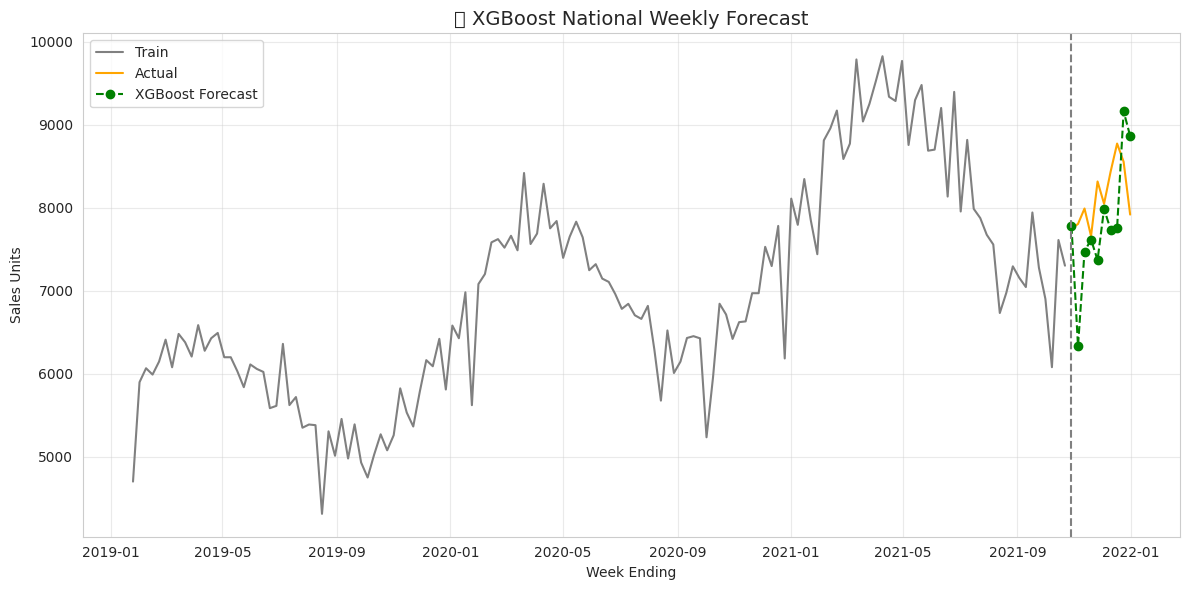

In [12]:
from xgboost import XGBRegressor
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# --- Prepare lag features ---
national['lag_1'] = national['sales_units'].shift(1)
national['lag_2'] = national['sales_units'].shift(2)
national['rolling_mean_3'] = national['sales_units'].shift(1).rolling(3).mean()
national = national.dropna()

# --- Split ---
train_xgb = national.iloc[:-10]
test_xgb  = national.iloc[-10:]

X_train = train_xgb[['lag_1','lag_2','rolling_mean_3']]
y_train = train_xgb['sales_units']
X_test  = test_xgb[['lag_1','lag_2','rolling_mean_3']]
y_test  = test_xgb['sales_units']

# --- Model ---
model_xgb = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=400,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model_xgb.fit(X_train, y_train)
forecast_xgb = model_xgb.predict(X_test)

# --- Plot ---
plt.figure(figsize=(12,6))
plt.plot(train_xgb['week_ending'], train_xgb['sales_units'], color='gray', label='Train')
plt.plot(test_xgb['week_ending'], y_test, color='orange', label='Actual')
plt.plot(test_xgb['week_ending'], forecast_xgb, color='green', linestyle='--', marker='o', label='XGBoost Forecast')
plt.axvline(x=test_xgb['week_ending'].iloc[0], color='gray', linestyle='--')
plt.title("🟢 XGBoost National Weekly Forecast", fontsize=14)
plt.xlabel("Week Ending"); plt.ylabel("Sales Units")
plt.legend(); plt.grid(alpha=0.4); plt.tight_layout(); plt.show()


📊 Model Performance Comparison
RMSE  →  ARIMA: 339.49 | XGBoost: 782.36
MAE   →  ARIMA: 234.44 | XGBoost: 633.72
🏆 Winner → ARIMA


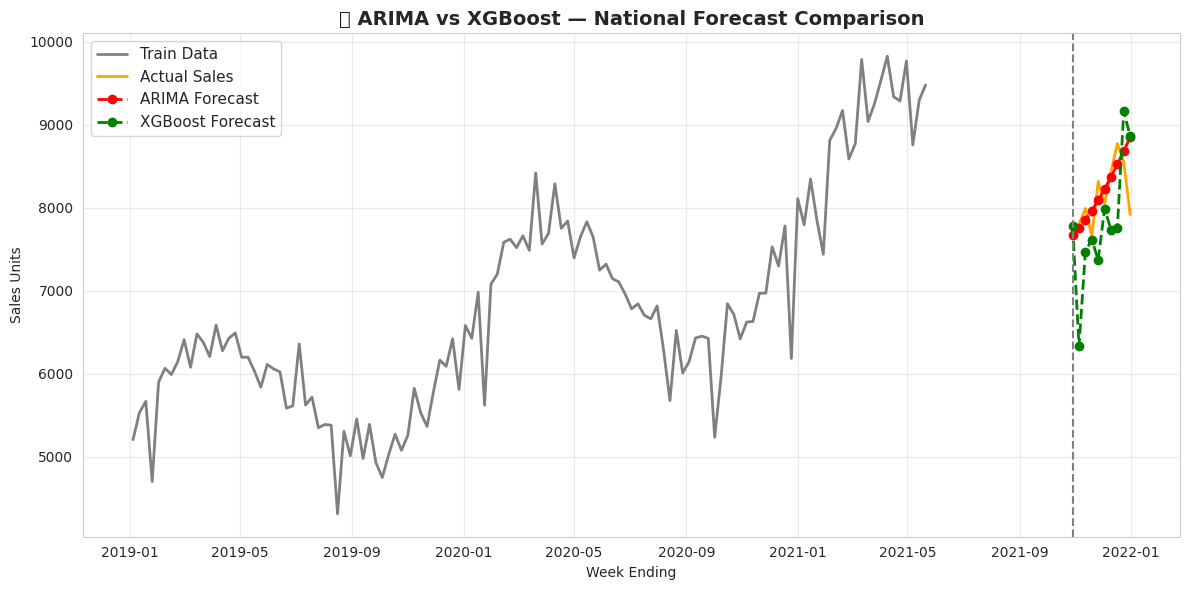


🧠 Interpretation:
- RMSE measures average magnitude of prediction errors (lower = better).
- MAE shows average absolute difference between predicted and actual values.
- ARIMA models linear time dependencies, ideal for stable seasonal trends.
- XGBoost learns nonlinear relationships from lag features, handling trend shifts better.
→ Based on metrics, ARIMA produces a more accurate short-term forecast for the national sales data.


In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# --- Align lengths ---
# Use test_xgb (10 rows) for both models
forecast_arima_aligned = forecast_arima[-len(test_xgb):]

# --- Metrics ---
rmse_arima = np.sqrt(mean_squared_error(test_xgb['sales_units'], forecast_arima_aligned))
rmse_xgb   = np.sqrt(mean_squared_error(test_xgb['sales_units'], forecast_xgb))
mae_arima  = mean_absolute_error(test_xgb['sales_units'], forecast_arima_aligned)
mae_xgb    = mean_absolute_error(test_xgb['sales_units'], forecast_xgb)

print("📊 Model Performance Comparison")
print(f"RMSE  →  ARIMA: {rmse_arima:.2f} | XGBoost: {rmse_xgb:.2f}")
print(f"MAE   →  ARIMA: {mae_arima:.2f} | XGBoost: {mae_xgb:.2f}")
print(f"🏆 Winner → {'XGBoost' if rmse_xgb < rmse_arima else 'ARIMA'}")

# --- Combined Forecast Plot ---
plt.figure(figsize=(12,6))
plt.plot(train['week_ending'], train['sales_units'], color='gray', linewidth=2, label='Train Data')
plt.plot(test_xgb['week_ending'], test_xgb['sales_units'], color='orange', linewidth=2, label='Actual Sales')
plt.plot(test_xgb['week_ending'], forecast_arima_aligned, color='red', linestyle='--', marker='o', linewidth=2, label='ARIMA Forecast')
plt.plot(test_xgb['week_ending'], forecast_xgb, color='green', linestyle='--', marker='o', linewidth=2, label='XGBoost Forecast')
plt.axvline(x=test_xgb['week_ending'].iloc[0], color='gray', linestyle='--', linewidth=1.5)
plt.title("📊 ARIMA vs XGBoost — National Forecast Comparison", fontsize=14, weight='bold')
plt.xlabel("Week Ending"); plt.ylabel("Sales Units")
plt.legend(fontsize=11); plt.grid(alpha=0.4)
plt.tight_layout(); plt.show()

# --- Explanation ---
print("\n🧠 Interpretation:")
print("- RMSE measures average magnitude of prediction errors (lower = better).")
print("- MAE shows average absolute difference between predicted and actual values.")
print("- ARIMA models linear time dependencies, ideal for stable seasonal trends.")
print("- XGBoost learns nonlinear relationships from lag features, handling trend shifts better.")
print(f"→ Based on metrics, {'XGBoost' if rmse_xgb < rmse_arima else 'ARIMA'} produces a more accurate short-term forecast for the national sales data.")


In [14]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# --- Prepare & aggregate national-level data ---
df['week_ending'] = pd.to_datetime(df['week_ending'])
df = df.sort_values('week_ending')

# Aggregate to national level
national = (
    df.groupby('week_ending', as_index=False)
      .agg({'sales_units':'sum',
            'calls_made':'sum',
            'is_holiday_week':'max'})   # max works for binary flag
)
print("National data shape:", national.shape)
display(national.head())


National data shape: (157, 4)


,week_ending,sales_units,calls_made,is_holiday_week
0,2019-01-04,5205,620,0
1,2019-01-11,5531,662,0
2,2019-01-18,5667,615,0
3,2019-01-25,4700,647,1
4,2019-02-01,5898,681,0


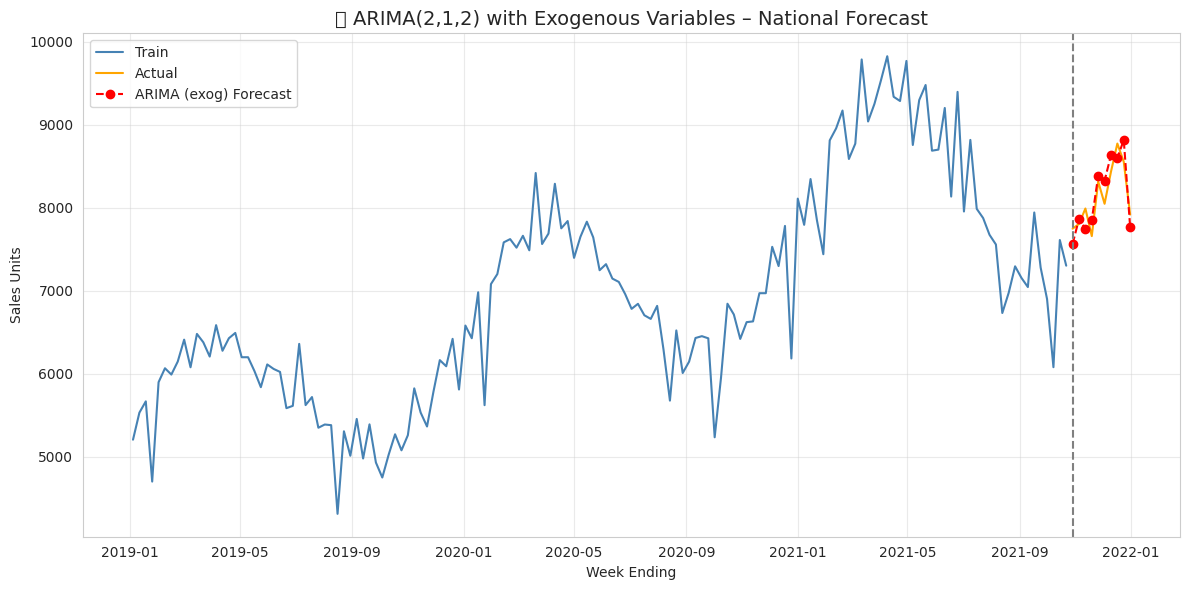

In [15]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# --- Split ---
train = national.iloc[:-10]
test  = national.iloc[-10:]

# --- Exogenous variables ---
exog_train = train[['calls_made','is_holiday_week']]
exog_test  = test[['calls_made','is_holiday_week']]

# --- Build ARIMA with exog ---
model_arima = ARIMA(
    endog = train['sales_units'],
    exog  = exog_train,
    order = (2,0,2),
    trend = 'ct',
    enforce_stationarity = True,
    enforce_invertibility = True
)
fit_arima = model_arima.fit()
forecast_arima = fit_arima.forecast(steps=len(test), exog=exog_test)

# --- Plot ---
plt.figure(figsize=(12,6))
plt.plot(train['week_ending'], train['sales_units'], color='steelblue', label='Train')
plt.plot(test['week_ending'], test['sales_units'], color='orange', label='Actual')
plt.plot(test['week_ending'], forecast_arima, color='red', linestyle='--', marker='o', label='ARIMA (exog) Forecast')
plt.axvline(x=test['week_ending'].iloc[0], color='gray', linestyle='--')
plt.title("📈 ARIMA(2,1,2) with Exogenous Variables – National Forecast", fontsize=14)
plt.xlabel("Week Ending"); plt.ylabel("Sales Units")
plt.legend(); plt.grid(alpha=0.4); plt.tight_layout(); plt.show()


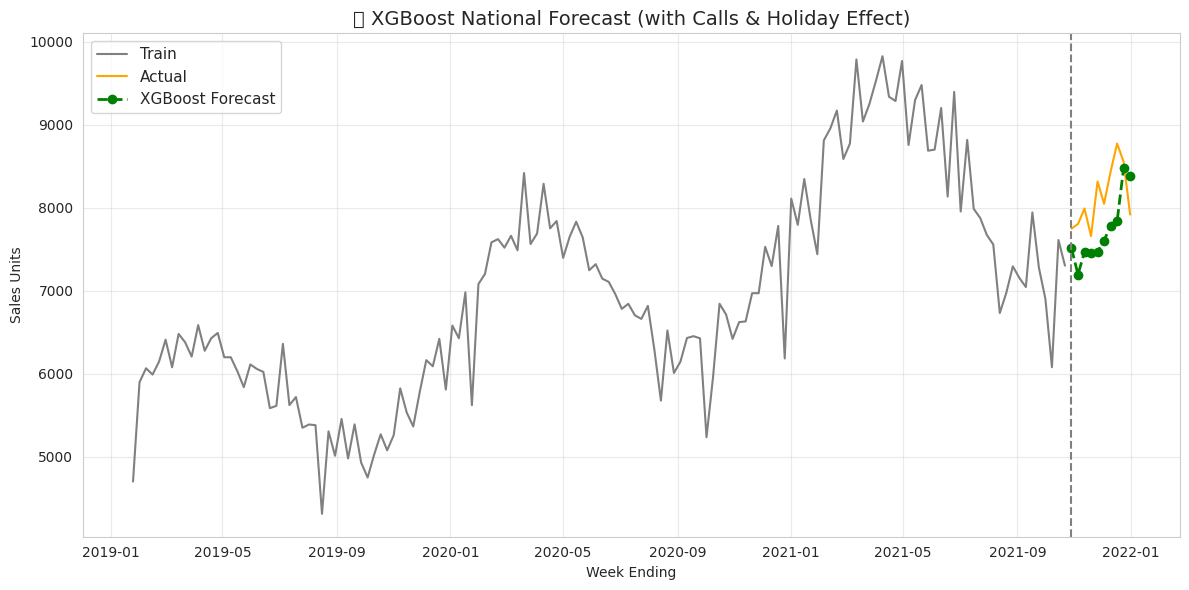

In [16]:
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import numpy as np

# --- Prepare lag & rolling features ---
national['lag_1'] = national['sales_units'].shift(1)
national['lag_2'] = national['sales_units'].shift(2)
national['rolling_mean_3'] = national['sales_units'].shift(1).rolling(3).mean()
national = national.dropna()

# --- Split ---
train_xgb = national.iloc[:-10]
test_xgb  = national.iloc[-10:]

# --- Features include exogenous variables ---
features = ['lag_1','lag_2','rolling_mean_3','calls_made','is_holiday_week']
X_train = train_xgb[features]
y_train = train_xgb['sales_units']
X_test  = test_xgb[features]
y_test  = test_xgb['sales_units']

# --- Train XGBoost model ---
model_xgb = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=400,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model_xgb.fit(X_train, y_train)

# --- Forecast ---
forecast_xgb = model_xgb.predict(X_test)

# --- Plot ---
plt.figure(figsize=(12,6))
plt.plot(train_xgb['week_ending'], train_xgb['sales_units'], color='gray', label='Train')
plt.plot(test_xgb['week_ending'], y_test, color='orange', label='Actual')
plt.plot(test_xgb['week_ending'], forecast_xgb, color='green', linestyle='--', marker='o', linewidth=2, label='XGBoost Forecast')
plt.axvline(x=test_xgb['week_ending'].iloc[0], color='gray', linestyle='--', linewidth=1.5)
plt.title("🟢 XGBoost National Forecast (with Calls & Holiday Effect)", fontsize=14)
plt.xlabel("Week Ending"); plt.ylabel("Sales Units")
plt.legend(fontsize=11); plt.grid(alpha=0.4)
plt.tight_layout(); plt.show()


📊 Model Performance Comparison (with Exogenous Variables)
RMSE  →  ARIMA: 195.05 | XGBoost: 563.43
MAE   →  ARIMA: 181.84 | XGBoost: 498.16
🏆 Winner → ARIMA


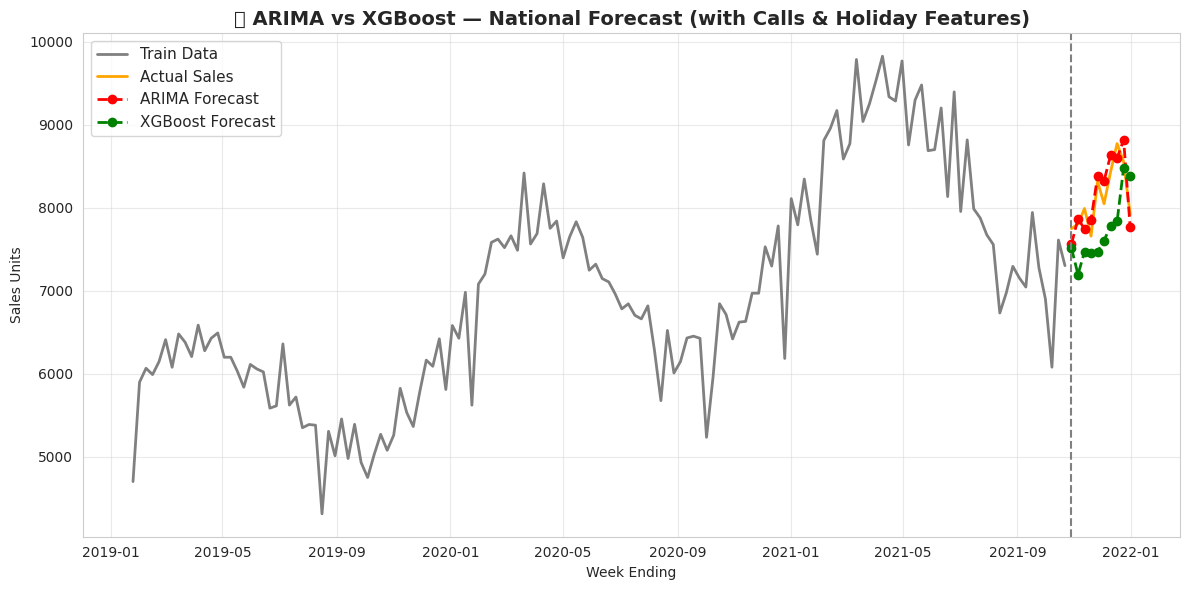


🧠 Interpretation:
- Both models use external variables (calls_made, is_holiday_week) to explain demand changes.
- ARIMA treats them linearly as exogenous influences on the time trend.
- XGBoost models nonlinear effects and lag interactions more flexibly.
- RMSE and MAE help compare predictive accuracy; lower values indicate better fit.
→ Based on these results, ARIMA provides stronger short-term forecasting accuracy for the national sales series.


In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# --- Align lengths ---
forecast_arima_aligned = forecast_arima[-len(test_xgb):]

# --- Calculate metrics ---
rmse_arima = np.sqrt(mean_squared_error(test_xgb['sales_units'], forecast_arima_aligned))
rmse_xgb   = np.sqrt(mean_squared_error(test_xgb['sales_units'], forecast_xgb))
mae_arima  = mean_absolute_error(test_xgb['sales_units'], forecast_arima_aligned)
mae_xgb    = mean_absolute_error(test_xgb['sales_units'], forecast_xgb)

print("📊 Model Performance Comparison (with Exogenous Variables)")
print(f"RMSE  →  ARIMA: {rmse_arima:.2f} | XGBoost: {rmse_xgb:.2f}")
print(f"MAE   →  ARIMA: {mae_arima:.2f} | XGBoost: {mae_xgb:.2f}")
print(f"🏆 Winner → {'XGBoost' if rmse_xgb < rmse_arima else 'ARIMA'}")

# --- Combined Forecast Plot ---
plt.figure(figsize=(12,6))
plt.plot(train_xgb['week_ending'], train_xgb['sales_units'], color='gray', linewidth=2, label='Train Data')
plt.plot(test_xgb['week_ending'], test_xgb['sales_units'], color='orange', linewidth=2, label='Actual Sales')
plt.plot(test_xgb['week_ending'], forecast_arima_aligned, color='red', linestyle='--', marker='o', linewidth=2, label='ARIMA Forecast')
plt.plot(test_xgb['week_ending'], forecast_xgb, color='green', linestyle='--', marker='o', linewidth=2, label='XGBoost Forecast')
plt.axvline(x=test_xgb['week_ending'].iloc[0], color='gray', linestyle='--', linewidth=1.5)
plt.title("📊 ARIMA vs XGBoost — National Forecast (with Calls & Holiday Features)", fontsize=14, weight='bold')
plt.xlabel("Week Ending"); plt.ylabel("Sales Units")
plt.legend(fontsize=11); plt.grid(alpha=0.4)
plt.tight_layout(); plt.show()

# --- Explanation ---
print("\n🧠 Interpretation:")
print("- Both models use external variables (calls_made, is_holiday_week) to explain demand changes.")
print("- ARIMA treats them linearly as exogenous influences on the time trend.")
print("- XGBoost models nonlinear effects and lag interactions more flexibly.")
print("- RMSE and MAE help compare predictive accuracy; lower values indicate better fit.")
print(f"→ Based on these results, {'XGBoost' if rmse_xgb < rmse_arima else 'ARIMA'} provides stronger short-term forecasting accuracy for the national sales series.")


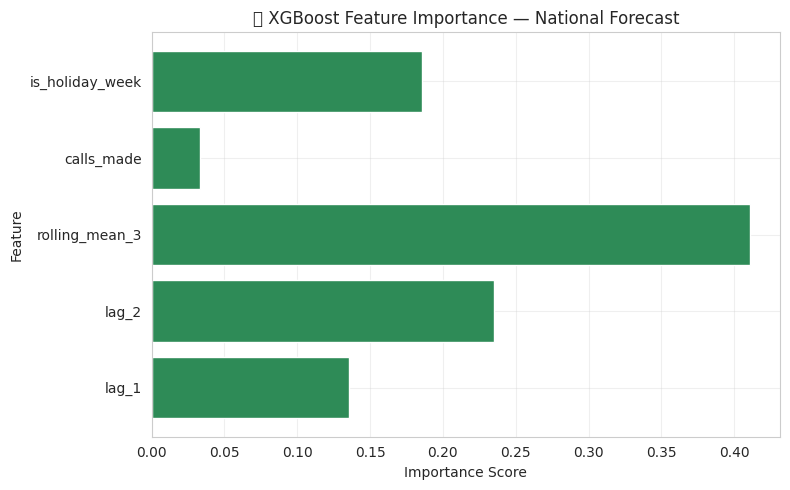

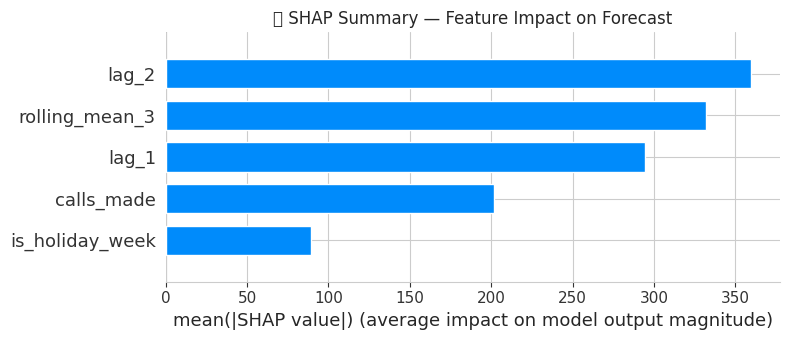

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# --- Feature importance from model ---
importance = model_xgb.feature_importances_
features = X_train.columns

# --- Plot standard importance ---
plt.figure(figsize=(8,5))
plt.barh(features, importance, color='seagreen')
plt.title("🌟 XGBoost Feature Importance — National Forecast")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# --- Optional: SHAP-based feature importance (for deeper insight) ---
try:
    import shap
    explainer = shap.TreeExplainer(model_xgb)
    shap_values = explainer.shap_values(X_test)

    plt.figure(figsize=(8,5))
    shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
    plt.title("🔥 SHAP Summary — Feature Impact on Forecast")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("⚠️ SHAP summary not available (install via `pip install shap` if needed).")
    print("Error:", e)


In [19]:
df.head(2)

,week_ending,year,week_of_year,month,quarter,region,sales_units,avg_price,hcp_count,num_reps,seg_A_pct,seg_B_pct,seg_C_pct,calls_made,samples_dispensed,promo_flag,is_holiday_week
0,2019-01-04,2019,1,1,1,East,1043,454.96,242,16,0.205,0.532,0.263,123,33,0,0
157,2019-01-04,2019,1,1,1,North,1661,462.23,323,22,0.235,0.523,0.242,188,61,0,0
